<a href="https://colab.research.google.com/github/ywang1110/NLP/blob/main/Quora_Question_Pairs_Similarity_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://miro.medium.com/max/1440/1*YulfXLgM6rhCtaJHDgPPtQ.png"
 height="200"/>


**Reference**:<br/>https://medium.com/analytics-vidhya/quora-question-pairs-similarity-problem-8e3ae90441f0 <br/>https://github.com/vedanshsharma/Quora-Questions-Pairs-Similarity-Problem

#Import libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

#Import the data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
train_set = pd.read_csv('/content/gdrive/My Drive/NLP project/data/train.csv')[0:120000]
test_set = pd.read_csv('/content/gdrive/My Drive/NLP project/data/test.csv')[0:30000]

In [ ]:
train_set.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
82065,82065,139246,139247,How tough is the GATE exam?,How tough is GATE Examination?,1
65638,65638,113883,113884,What is your experience with using proto-perso...,Can you paint a picture in a space ship?,0
56583,56583,11917,99571,How does it feel to fall out of love?,Can we fall out of love?,1
107997,107997,177541,124233,Which intersections in Detroit are particularl...,"Which intersections in Portland, OR are partic...",0
17663,17663,33528,33529,"What is more important, knowledge or marks?",Is imagination more important than knowledge i...,0


In [ ]:
test_set.sample(5)

,test_id,question1,question2
23822,23822,I Need tableau experts what's app group?,What hatches from 10 km eggs in Pokémon GO?
23818,23818,What is the street price for Percocet 10/325?,The total price of bat and ball is 1.10₹. The ...
6652,6652,Should I settle in Canada or problem?,What is the muslims way to settle in Canada?
19207,19207,What code feature metro or underground transpo...,How do Metro PCS's plans?
28860,28860,What real-life the relationship of philosophy ...,Do Ceres and other dwarf planets abide by the ...


In [ ]:
train_questions1 = train_set['question1'].tolist()
train_questions2 = train_set['question2'].tolist()
test_questions1 = test_set['question1'].tolist()
test_questions2 = test_set['question2'].tolist()

In [ ]:
questions = train_questions1 + train_questions2 + test_questions1 + test_questions2
questions = list(map(str, questions)) # map -> iterator 
len(questions)

300000

#Tokenization

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'\w+') # only words

In [ ]:
sentences = []
for p in tqdm.tqdm(questions):
  sentences.append(tokenizer.tokenize(str(p)))

100%|██████████| 300000/300000 [00:02<00:00, 136021.53it/s]


In [ ]:
print(questions[0:2])
print(sentences[0:2])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?']
[['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], ['What', 'is', 'the', 'story', 'of', 'Kohinoor', 'Koh', 'i', 'Noor', 'Diamond']]


In [ ]:
def get_words(input_sentences):
  output_sentences = []
  for p in input_sentences:
    output_sentences.append(tokenizer.tokenize(str(p)))
  return output_sentences

In [ ]:
train_questions1_words = get_words(train_questions1)
train_questions2_words = get_words(train_questions2)
test_questions1_words = get_words(test_questions1)
test_questions2_words = get_words(test_questions2)

##TF-IDF (Term Frequency — Inverse Document Frequency)
Compute a weight to each word which signifies the importanace of the word in the document and corpus. <br/>
TF-IDF = Term Frequency (TF)*Inverse Document Frequency (IDF)
**output** weight(scalar)
---
*  **Term frequency (TF)**: frequency of a word in a document (highly depends on the length of the document and the generality of word) <br/> TF is individually to each document and word<br/> ***tf(t,d) = count of t in d / number of words in d***


*  Why not just use TF?<br/>
1. common words, as well as stop-words (e.g. is am are) will have very high values and give those words a very high importance
2. 

---
*  **Document Frequency:** the number of documents in which the word is present.We consider one occurrence if the term consists in the document at least once, we do not need to know the number of times the term is present.<br/> ***df(t) = occurrence of t in documents***
---
**Inverse Document Frequency**
idf(t) = N/df


*   Large corpus -> IDF explodes <br/>idf(t) = log(N/df)
*   word which is not in vocab <br/>df=0 -> idf(t)=log(N/(df+1))


---
*  t-term (word)
*  d-document(set of words)
*  N-count of corpus
*  corpus-the total document set

**Basis version of IF-IDF score:**<br/>
tf-idf(t,d) = tf(t,d)*log(N/(df+1))




https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [ ]:
from gensim import corpora
from gensim.models import TfidfModel

In [ ]:
dictionary = corpora.Dictionary(sentences)  # implements the concept of a Dictionary – a mapping between words and their integer ids.
new_corpus = [dictionary.doc2bow(txt) for txt in sentences] # Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

In [ ]:
tfidf=TfidfModel(new_corpus) # implements functionality related to the TF-IDF              # fit model

In [ ]:
tfidf[dictionary.doc2bow(['what', 'is', 'this'])] # (token_id, token_count) 

[(6, 0.2407849128206825), (62, 0.6570005267016968), (899, 0.7144039009353386)]

In [ ]:
def get_sentences_tfidfs(input_sentences):
  output_vectors = []
  for p in input_sentences:
    result = tfidf[dictionary.doc2bow(p)]
    output_vectors.append(result)
  return output_vectors

In [ ]:
train_questions1_tfidfs = get_sentences_tfidfs(train_questions1_words)
train_questions2_tfidfs = get_sentences_tfidfs(train_questions2_words)
test_questions1_tfidfs = get_sentences_tfidfs(test_questions1_words)
test_questions2_tfidfs = get_sentences_tfidfs(test_questions2_words)

In [ ]:
print(train_questions2_words[1])
print(train_questions2_tfidfs[1])

['What', 'would', 'happen', 'if', 'the', 'Indian', 'government', 'stole', 'the', 'Kohinoor', 'Koh', 'i', 'Noor', 'diamond', 'back']
[(0, 0.03689174260974629), (10, 0.07414068369213528), (13, 0.407445916466027), (14, 0.3949851825339399), (15, 0.426363561046035), (16, 0.21677330542161743), (129, 0.13776037832366533), (216, 0.20673749251608306), (256, 0.19268540207594384), (458, 0.16456260111687418), (584, 0.1273697522946146), (905, 0.1904640344823664), (4950, 0.39004005192886004), (9772, 0.3343388492302425)]


In [ ]:
dictionary[1]

'by'

#Word2Vec
The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling
* Skip-gram: word -> words in a window
* CBOW: words (windows) -> word   <br/>

output: vector/embedding of words

In [ ]:
from gensim.models import Word2Vec

In [ ]:
word2vec = Word2Vec(sentences=sentences, size=100, window=8, iter=10, min_count=1)

In [ ]:
word2vec.wv.similarity('person', 'man')

0.68729866

In [ ]:
word2vec.wv.vocab['man'].count

1078

In [ ]:
len(word2vec.wv.vocab)

71020

##Train Word2Vector/GloVe
* based on our data
 - Pros: 
 - Cons: 
* based on pulibic Corpus
 - Pros: General
 - Cons: costly
* **Load models (e.g. twitter.27B)** 
 - Pros: 
 - Cons:


##Word vectors --> Sentence Vectors

1. Merge: Max, Average, '[w1, w2, w3, ...., wn]'  <br/>*e.g. w1 100-d vector*
2. TF-IDF: weighted sum
3. Deep learning: embedding, '[f1, f2, ..., fn]' (LSTM, GRU, Attention) <br/> f---> feature<br/>
    - Last output: fn as 
    - Hidden Vector (LSTM, GRU), hn
    - Attention: '[aw1, aw2, ... , awn]' (attention weights), weighted sum -> sentence vector

4. Doc2Vec: sentence ---> embedding (BERT sentence embedding)


#Construct TF-IDF & Word2Vactor Feasure

In [ ]:
train_questions1_tfidfs[0]  # (dict_id, weight)

[(0, 0.04647779709270368),
 (1, 0.1822570720039786),
 (2, 0.3795121200789133),
 (3, 0.14339205961233994),
 (4, 0.2743635788477922),
 (5, 0.2887230565095903),
 (6, 0.0641007660924909),
 (7, 0.27256152978155446),
 (8, 0.30337312129044286),
 (9, 0.6810270327800437),
 (10, 0.046702804058475544),
 (11, 0.07058432928597289)]

In [ ]:
dictionary[2]

'guide'

In [ ]:
word2vec.wv['by'].shape

(100,)

In [ ]:
y=train_questions1_tfidfs[0] 
y[0]

(0, 0.04647779709270368)

In [ ]:
def get_features(input_sentences, sentence_tfidfs, word2vec, dictionary):
    output_features = []
    for p, tf_idf in zip(input_sentences, sentence_tfidfs):
        sentence_features = [word2vec.wv[dictionary[x[0]]]*x[1] for x in tf_idf]
        output_features.append(np.array(sentence_features).sum(0))
    return output_features

In [ ]:
train_questions1_features = get_features(train_questions1, train_questions1_tfidfs, word2vec, dictionary)
train_questions2_features = get_features(train_questions2, train_questions2_tfidfs, word2vec, dictionary)
test_question1_features = get_features(test_questions1_words, test_questions1_tfidfs, word2vec, dictionary)
test_question2_features = get_features(test_questions2_words, test_questions2_tfidfs, word2vec, dictionary)

In [ ]:
len(train_questions1_tfidfs)

120000

In [ ]:
train_questions1_features[10].shape

(100,)

##Train and Test data preparation

*  **conact**  100-d vectors(2) ->  200-d vector (1)
*  **product** 100-d vectors(2) ->  200-d vector (1)  

cosine = **x*y**/(|x|*|y|)

In [72]:
def fuse_question1_question2_by_concat(question1, question2):
  fused_results = []
  for q1, q2 in zip(question1, question2):
    f = np.zeros(200)
    f[0:100] = q1
    f[100:200] = q2
    fused_results.append(f)
  return np.array(fused_results)

In [73]:
train_features = fuse_question1_question2_by_concat(train_questions1_features, train_questions2_features) 
test_features = fuse_question1_question2_by_concat(test_question1_features, test_question2_features)

In [ ]:
train_features.shape

(120000, 200)

In [ ]:
train_labels = train_set['is_duplicate']
train_labels

0         0
1         0
2         0
3         0
4         0
         ..
119995    0
119996    0
119997    0
119998    1
119999    0
Name: is_duplicate, Length: 120000, dtype: int64

# Train and Test

##XGBoost

In [74]:
import xgboost as xgb

In [75]:
params = {
    'booster':'gbtree',    # gbtree or gblinear
    'objective':'binary:logistic', # onjective: specify the learning task and corresponding learning objective, users can pass a self-defined function to it. | 'binary:logstic' output probability 
    'eval_metric':'logloss',  
    'max_depth':10, # default=6
    'lambda':1,    # L2 regularization term on weihghts, default=0
    'subsample':0.75, # 0.75 means that xgboost only randomly collected 75% of the training data instance to grow the tree and this will prevent overfitting
    'colsample_bytree':0.75,  # 0.75 means that only 75% columns are collected when constructing each tree 
    'eta':0.2,  # eta controls the learning rate 
    'seed':0,  # 
    'nthread':8
}

In [76]:
dtrain = xgb.DMatrix(train_features, label=train_labels)

In [77]:
watch_list = [(dtrain, 'dtrain')]
bst = xgb.train(params, dtrain, num_boost_round=50, evals=watch_list)

[0]	dtrain-logloss:0.643647
[1]	dtrain-logloss:0.606197
[2]	dtrain-logloss:0.578421
[3]	dtrain-logloss:0.55562
[4]	dtrain-logloss:0.537007
[5]	dtrain-logloss:0.519337
[6]	dtrain-logloss:0.503466
[7]	dtrain-logloss:0.491285
[8]	dtrain-logloss:0.478895
[9]	dtrain-logloss:0.467152
[10]	dtrain-logloss:0.455068
[11]	dtrain-logloss:0.445136
[12]	dtrain-logloss:0.436252
[13]	dtrain-logloss:0.427828
[14]	dtrain-logloss:0.421236
[15]	dtrain-logloss:0.414793
[16]	dtrain-logloss:0.407904
[17]	dtrain-logloss:0.400684
[18]	dtrain-logloss:0.395607
[19]	dtrain-logloss:0.391002
[20]	dtrain-logloss:0.384895
[21]	dtrain-logloss:0.380158
[22]	dtrain-logloss:0.374163
[23]	dtrain-logloss:0.368774
[24]	dtrain-logloss:0.363606
[25]	dtrain-logloss:0.356975
[26]	dtrain-logloss:0.353511
[27]	dtrain-logloss:0.348539
[28]	dtrain-logloss:0.343842
[29]	dtrain-logloss:0.336946
[30]	dtrain-logloss:0.333441
[31]	dtrain-logloss:0.331383
[32]	dtrain-logloss:0.326381
[33]	dtrain-logloss:0.321453
[34]	dtrain-logloss:0.319

In [78]:
dtest = xgb.DMatrix(test_features)
ypred = bst.predict(dtest)

##Netrual Network

In [79]:
import tensorflow as tf

In [80]:
tf.__version__

'2.5.0'

In [87]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation

In [92]:
model=Sequential()
model.add(Dense(units=256, input_dim=200, activation='relu'))
model.add(Dense(units=256, input_dim=256, activation='relu'))
model.add(Dense(units=1, input_dim=256, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01,momentum=0.9))

In [93]:
model.fit(train_features, train_labels, epochs=10, batch_size=128)

Epoch 1/10
938/938 [==============================] - 11s 5ms/step - loss: 0.5653
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.4785
Epoch 3/10
938/938 [==============================] - 5s 5ms/step - loss: 0.4506
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.4247
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.4081
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.3928
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3720
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3590
Epoch 9/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3425
Epoch 10/10
938/938 [==============================] - 5s 5ms/step - loss: 0.3284


In [94]:
ypred=model.predict(test_features, batch_size=100)

#EDA

In [ ]:
b

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            120000 non-null  int64 
 1   qid1          120000 non-null  int64 
 2   qid2          120000 non-null  int64 
 3   question1     120000 non-null  object
 4   question2     119999 non-null  object
 5   is_duplicate  120000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 5.5+ MB


##Distribution of data points among output class

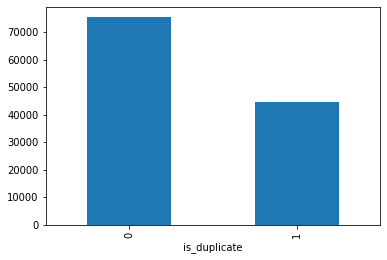

In [ ]:
train_set.groupby('is_duplicate')['id'].count().plot(kind='bar')

In [ ]:
percentage_noDup = np.mean(train_set['is_duplicate']==0)
percentage_Dup = np.mean(train_set['is_duplicate']==1)

In [ ]:
print('Percentage Question pairs that are not duplicate = {:.2f}%'.format(percentage_noDup*100))
print('Percentage Question pairs that are not duplicate = {:.2f}%'.format(percentage_Dup*100))

Percentage Question pairs that are not duplicate = 62.79%
Percentage Question pairs that are not duplicate = 37.21%


##Unique vs. repeated Questions

In [ ]:
qids=pd.Series(train_set['qid1'].tolist()+train_set['qid2'].tolist())
qids=qids.value_counts()
qids

2559      40
4044      33
30782     31
17978     25
18753     24
          ..
142231     1
140182     1
146325     1
144276     1
159758     1
Length: 194716, dtype: int64

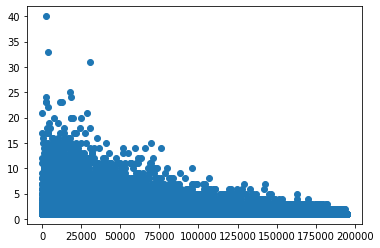

In [ ]:
plt.scatter(qids.index, qids)

In [ ]:
unique_ids=qids.index
print('Number of unique ids={}'.format(len(unique_ids)))

Number of unique ids=194716


In [ ]:
qs_morethan_onetime=np.sum(qids>1)
print('Number of unique questions that appears more than once={}'.format(np.sum(qids>1)))
percentage_morethan_once=np.mean(qids>1)
print('Percentage of unique questions that appears more than once={:.2f}%'.format(percentage_morethan_once*100))

Number of unique questions that appears more than once=24750
Percentage of unique questions that appears more than once=12.71%


In [ ]:
qs_max=np.max(qids)
qs_max
print('Max number of times a single question is repeated={}'.format(qs_max))

Max number of times a single question is repeated=40


In [ ]:
# check if there are any duplicated pair of questions
pair_duplicates=train_set.groupby(['qid1','qid2'])['id'].count()
pair_duplicates

qid1    qid2  
1       2         1
3       4         1
4       32881     1
5       6         1
7       8         1
                 ..
194707  194708    1
194709  194710    1
194711  171467    1
194712  194713    1
194715  194716    1
Name: id, Length: 120000, dtype: int64

In [ ]:
if np.sum(pair_duplicates>1)==0:
  print('There is no duplicate pair of questions')

There is no duplicate pair of questions


##Frequency of different questions

In [ ]:
qids

2559      40
4044      33
30782     31
17978     25
18753     24
          ..
142231     1
140182     1
146325     1
144276     1
159758     1
Length: 194716, dtype: int64

Text(0, 0.5, 'Count')

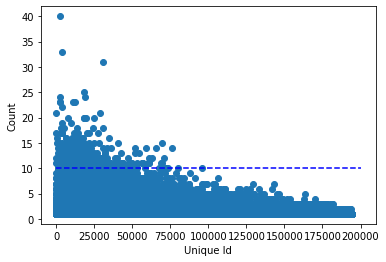

In [ ]:
plt.scatter(qids.index, qids)
plt.hlines(y=10, xmax=200000, xmin=0, linestyles='dashed', colors='b')
plt.xlabel('Unique Id')
plt.ylabel('Count')

##Missing values

In [ ]:
train_set.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
train_set[train_set.isnull().any(axis=1)]   # check if 'True' is present in rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
#Fill an empty space inplace of Null value
train_set=train_set.fillna('')
train_set.isnull().sum(axis=0)

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
train_set[train_set.isnull().any(axis=1)] # we don't have any Null value in our dataframe

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
test_set=test_set.fillna('')
test_set[test_set.isnull().any(axis=1)]

,test_id,question1,question2


##Basic Feature Extraction

**New features construction**<br/>

*   **freq_qid1**=Frequency of qid1
*   **freq_qid2**=Frequency of qid2
*   **q1len**=Length of q1 (Characters+space)
*   **q2len**=Length of q2
*   **q1_n_words**=Number of words in Question 1
*   **q2_n_words**=Number of words in Question 2
*   **word_Common**=Number of common words in question 1 and question 2
*   **word_Total**=Total number of word in question 1 and question 2
*   **word_Share**=word_Common/Total_word
*   **freq_q1+freq_q2**=sum total of frequency of qid1 and qid2
*   **freq_q1-freq_q2**=absoulte difference of frequency of qid1 and qid2




In [ ]:
train_set.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
train_set['freq_qid1']=train_set.groupby('qid1')['id'].transform('count')  # pandas.DataFrame.transform -> Call func on self producing a DataFrame with transformed values|same lenght - similar with window function in SQL
train_set['freq_qid2']=train_set.groupby('qid2')['id'].transform('count')  
train_set['q1len']=train_set['question1'].str.len()  # pandas.Series.str.len -> Compute the length of each element in string (characters+spaces)
train_set['q2len']=train_set['question2'].str.len()
train_set['q1_n_words']=train_set['question1'].apply(lambda x: len(str(x).split(' ')))
train_set['q2_n_words']=train_set['question2'].apply(lambda x: len(str(x).split(' ')))

In [ ]:
def normalized_word_Common(row):
  w1=set(map(lambda x: x.lower().strip(), str(row['question1']).split(' ')))
  w2=set(map(lambda x: x.lower().strip(), str(row['question2']).split(' ')))
  return 1.0*len(w1 & w2)
train_set['word_Common']=train_set.apply(normalized_word_Common, axis=1)

In [ ]:
def normalized_word_Total(row):
  w1=set(map(lambda x: x.lower().strip(), str(row['question1']).split(' ')))
  w2=set(map(lambda x: x.lower().strip(), str(row['question2']).split(' ')))
  return (len(w1)+len(w2))*1.0
train_set['word_Total']=train_set.apply(normalized_word_Total, axis=1)

In [ ]:
train_set['word_share']=train_set['word_Common']/train_set['word_Total']
train_set['freq_q1+freq_q2']=train_set['freq_qid1']+train_set['freq_qid2']
train_set['freq_q1-freq_q2']=np.abs(train_set['freq_qid1']-train_set['freq_qid2'])

In [ ]:
train_set.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
train_set.describe()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198,2.827609,3.046961,59.536709,60.108365,10.944592,11.185120,4.511610,21.126112,0.223362,5.874570,1.845715
std,116708.614503,157751.700002,159903.182629,0.482588,4.487418,6.026871,29.940655,33.863870,5.431949,6.311076,3.098656,8.592622,0.128336,9.091068,5.187882
min,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000,1.000000,1.000000,39.000000,39.000000,7.000000,7.000000,2.000000,15.000000,0.125000,2.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000,1.000000,1.000000,52.000000,51.000000,10.000000,10.000000,4.000000,19.000000,0.217391,3.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000,3.000000,2.000000,72.000000,72.000000,13.000000,13.000000,6.000000,25.000000,0.318182,5.000000,2.000000
max,404289.000000,537932.000000,537933.000000,1.000000,50.000000,120.000000,623.000000,1169.000000,125.000000,237.000000,41.000000,166.000000,0.500000,157.000000,119.000000


In [ ]:
print('Minimum length of the questions in question1 = {}'.format(np.min(train_set['q1_n_words'])))
print('Minimum length of the questions in question2 = {}'.format(np.min(train_set['q2_n_words'])))
print('Number of questions with minimum length in question1 = {}'.format((train_set['q1_n_words']==1).sum()))
print('Number of questions with minimum length in question2 = {}'.format((train_set['q2_n_words']==1).sum()))

Minimum length of the questions in question1 = 1
Minimum length of the questions in question2 = 1
Number of questions with minimum length in question1 = 67
Number of questions with minimum length in question2 = 24


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


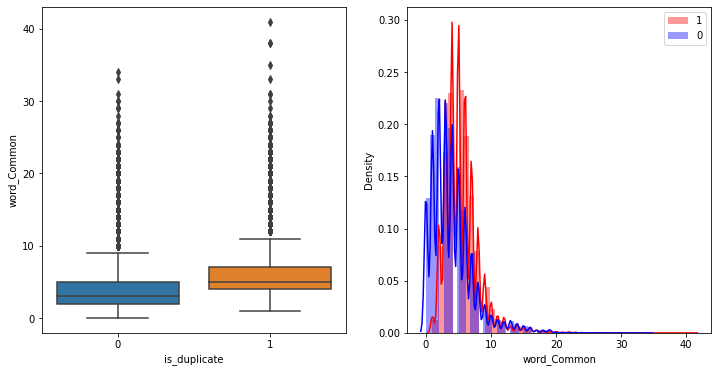

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.boxplot(x = 'is_duplicate', y = 'word_Common', data = train_set)

plt.subplot(1,2,2)
sns.distplot(train_set[train_set['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'red')
sns.distplot(train_set[train_set['is_duplicate'] == 0.0]['word_Common'], label = "0" , color = 'blue' )
plt.legend()
plt.show()



*   The distribution of the word_Common feature in duplicate or non-duplicate pair are highly overlap. Therefore, this feature can not be used for classification



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


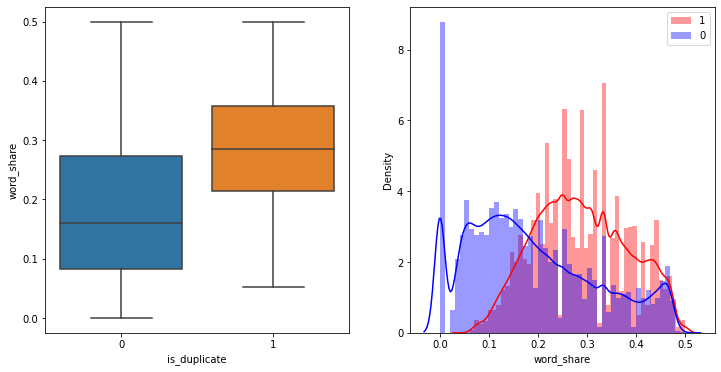

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.boxplot(x = 'is_duplicate', y = 'word_share', data = train_set)

plt.subplot(1,2,2)
sns.distplot(train_set[train_set['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(train_set[train_set['is_duplicate'] == 0.0]['word_share'], label = "0" , color = 'blue' )
plt.legend()
plt.show()



*  The average word share of qid1 and qid2 is more **when they are duplicate**(Similar) 



#Processing of Text (Text normalization)

##Import library

In [ ]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

##preprocessing

###Lowercase

In [ ]:
def convert_lower_case(data):
  return np.char.lower(data)

###Removing stop words

In [ ]:
def remove_stop_words(data):
  stop_words = stopwords.words('english')
  words = word_tokenize(str(data))
  new_text=""
  for w in words:
    if w not in stop_words and len(w)>1:
      new_text = new_text+" "+w
  return data

###Removing punctuation

In [ ]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

###Removing apostrophe

In [ ]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

###Stemming

In [ ]:
def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

###convert_numbers

In [ ]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_tex

In [ ]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

##**Advanced Feature Extraction** (NLP and Fuzzy Features)

**Definition:**<br/>


*   **Token:** Get a token by spliting a space
*   **Stop_Word:** Stop word as per NLTK
*   **Word:** A token that is not a stop_word




In [ ]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [ ]:
# Try

In [ ]:
sentences = []
for s in tqdm.tqdm(train_set['question1'].tolist()):
  sentences.append(tokenizer.tokenize(str(s)))

100%|██████████| 120000/120000 [00:00<00:00, 224404.93it/s]


In [ ]:
print(train_set['question1'].tolist()[0:2])
print(sentences[0:2])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?']
[['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], ['What', 'is', 'the', 'story', 'of', 'Kohinoor', 'Koh', 'i', 'Noor', 'Diamond']]


In [ ]:
train_questions1 = train_set['question1'].tolist()
train_questions1_words = get_words(train_set['question1'])
train_questions2_words = get_words(train_set['question2'])
test_questions1_words = get_words(test_set['question1'])
test_questions2_words = get_words(test_set['question2'])

In [ ]:
# Check
print(test_set['question2'].tolist()[0:2])
print(test_questions2_words[0:2])

['Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?', 'How much cost does hair transplant require?']
[['Why', 'did', 'Microsoft', 'choose', 'core', 'm3', 'and', 'not', 'core', 'i3', 'home', 'Surface', 'Pro', '4'], ['How', 'much', 'cost', 'does', 'hair', 'transplant', 'require']]




1.   Vectorize the documents on the vocab (the list of all possible words in the corpus)<br/>





In [ ]:
from gensim import corpora
from gensim.models import TfidfModel

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
sentences=[]
for p in tqdm.tqdm(questions):
  sentences.append(tokenizer.tokenize(p))

100%|██████████| 300000/300000 [00:01<00:00, 163105.75it/s]


In [ ]:
print(questions[0:2])
print(sentences[0:2])

['What is the step by step guide to invest in share market in india?', 'What is the story of Kohinoor (Koh-i-Noor) Diamond?']
[['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], ['What', 'is', 'the', 'story', 'of', 'Kohinoor', 'Koh', 'i', 'Noor', 'Diamond']]


In [ ]:
dictionary = corpora.Dictionary(sentences) # implements the concept of a Dictionary – a mapping between words and their integer ids.

In [ ]:
new_corpus = [dictionary.doc2bow(txt) for txt in sentences] # Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.
# Convert corpus to BoW format

In [ ]:
tfidf=TfidfModel(new_corpus) # implements functionality related to the TF-IDF              # fit model

In [ ]:
tfidf[dictionary.doc2bow(['what', 'is', 'this'])] # (token_id, token_count) 

[(6, 0.2407849128206825), (62, 0.6570005267016968), (899, 0.7144039009353386)]

In [ ]:
def get_sentences_tfidfs(input_sentences):
  output_vectors = []
  for p in input_sentences:
    result = tfidf[dictionary.doc2bow(p)]
    output_vectors.append(result)
  return output_vectors

In [ ]:
train_questions1_tfidfs = get_sentences_tfidfs(train_questions1_words)

In [ ]:
train_questions2_tfidfs = get_sentences_tfidfs(train_questions2_words)

In [ ]:
test_questions1_tfidfs = get_sentences_tfidfs(test_questions1_words)
test_questions2_tfidfs = get_sentences_tfidfs(test_questions2_words)

In [ ]:
print(train_questions2_words[0])
print(train_questions2_tfidfs[0])

['What', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market']
[(0, 0.04874062176007606), (1, 0.19113046584213902), (2, 0.39798910136028665), (3, 0.07518663295318391), (5, 0.3027798684752248), (6, 0.06722158514555926), (7, 0.28583149934866364), (8, 0.31814318840237005), (9, 0.7141836121645693), (10, 0.048976583447119755), (11, 0.07402080802268367)]


In [ ]:
dictionary[1]

'by'

In [ ]:
sentences = sentences[0:10000]  # reduce sample size

In [ ]:
word2vec = Word2Vec(sentences=sentences, size=50, window=8, iter=10, min_count=1)

In [ ]:
print('person vs man: ', word2vec.wv.similarity('person', 'man'))
print('ocean vs sea : ', word2vec.wv.similarity('ocean', 'sea'))b

SyntaxError: ignored

In [ ]:
word2vec.wv.vocab['man'].count

In [ ]:
len(word2vec.wv.vocab)

###Word vector ---> sentence vector

* Direct Merge: Max, Average, `[w1,w2, w3, ...., wn]`  `w1 100-d vector`

* TF-IDF: weighted sum

* Deep Learning: embeddings, `[f1, f2,...,fn]` (f --> feature) (LSTM, GRU, Attention)

    - Last Output: fn
    - Hidden Vector (LSTM, GRU), hn
    - Attention: `[aw1, aw2, .... ,awn]`  (attention weights), weighted sum -> sentence vector

## Word2Vector or GloVe？

* Our data (-)
* Public Corups (general, training budget)
* Load models, twitter.27B

* Huge dataset: training by yourself
* small dataset: public models
* normal dataset： load public models ---> update model 

`embedding layer` ---> load weights & fine-tuning (classification/translation)


> Indented block



### Load word vectors from pretrained

use `gensim.models.KeyedVectors`

download the model first, such as `glove.6B.100d.txt` from https://nlp.stanford.edu/projects/glove/

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
glove_vector_path = '/content/gdrive/My Drive/NLP project/data/glove.twitter.27B.100d.txt'

####convert glove style to gensim style
Glove txts have different styles from gensim. You need convert the styles of glove txts for usage

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_file = datapath(glove_vector_path)
tmp_file = get_tmpfile("converted_glove.txt")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
_ = glove2word2vec(glove_file, tmp_file)